In [2]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/teo/userdata/git_libraries/Yeominrak


In [3]:
import torch
from pathlib import Path
import wandb 
from torch.utils.data import DataLoader
import datetime
import random as random
from omegaconf import DictConfig, OmegaConf
import hydra

from music21 import converter, stream, note as m21_note 
from typing import List, Set, Dict, Tuple

import yeominrak_processing
from yeominrak_processing import pack_collate
import model_zoo
import trainer
from model_zoo import get_emb_total_size
from loss import nll_loss, focal_loss
from decode import MidiDecoder, OrchestraDecoder
from torch.nn.utils.rnn import pack_sequence, PackedSequence, pad_packed_sequence, pack_padded_sequence
from trainer import Trainer, RollTrainer
from fractions import Fraction

In [29]:
config = OmegaConf.load('yamls/orchestration.yaml')
config = get_emb_total_size(config)

val_dataset = yeominrak_processing.OrchestraScore(is_valid= True,
                            # valid_measure_num = [i for i in range(93, 99)],
                            xml_path='yeominlak_omr5.musicxml', 
                            use_pitch_modification=False, 
                            slice_measure_num=config.data.max_meas,
                            min_meas=config.data.min_meas,
                            feature_types=config.model.features,
                              sampling_rate=config.data.sampling_rate)


In [35]:
val_dataset.result_pairs

[[7, 0, [93, 94, 95, 96]],
 [7, 0, [94, 95, 96, 97]],
 [7, 0, [95, 96, 97, 98]],
 [7, 0, [96, 97, 98, 99]],
 [7, 0, [97, 98, 99, 100]],
 [7, 0, [98, 99, 100, 101]],
 [7, 0, [99, 100, 101, 102]],
 [7, 1, [93, 94, 95, 96]],
 [7, 1, [94, 95, 96, 97]],
 [7, 1, [95, 96, 97, 98]],
 [7, 1, [96, 97, 98, 99]],
 [7, 1, [97, 98, 99, 100]],
 [7, 1, [98, 99, 100, 101]],
 [7, 1, [99, 100, 101, 102]],
 [7, 2, [93, 94, 95, 96]],
 [7, 2, [94, 95, 96, 97]],
 [7, 2, [95, 96, 97, 98]],
 [7, 2, [96, 97, 98, 99]],
 [7, 2, [97, 98, 99, 100]],
 [7, 2, [98, 99, 100, 101]],
 [7, 2, [99, 100, 101, 102]],
 [7, 3, [93, 94, 95, 96]],
 [7, 3, [94, 95, 96, 97]],
 [7, 3, [95, 96, 97, 98]],
 [7, 3, [96, 97, 98, 99]],
 [7, 3, [97, 98, 99, 100]],
 [7, 3, [98, 99, 100, 101]],
 [7, 3, [99, 100, 101, 102]],
 [7, 4, [93, 94, 95, 96]],
 [7, 4, [94, 95, 96, 97]],
 [7, 4, [95, 96, 97, 98]],
 [7, 4, [96, 97, 98, 99]],
 [7, 4, [97, 98, 99, 100]],
 [7, 4, [98, 99, 100, 101]],
 [7, 4, [99, 100, 101, 102]],
 [7, 5, [93, 94, 95, 96]]

In [31]:

model = model_zoo.QkvAttnSeq2seqOrch(val_dataset.era_dataset.tokenizer, val_dataset.tokenizer, config.model)
model.is_condition_shifted = True
# if 'offset' in model.tokenizer.tok2idx:
#   for i in range(120):
#     if i % 4 == 0:
#       continue
#     if i / 4 not in model.tokenizer.tok2idx['offset']:
#       model.tokenizer.tok2idx['offset'][i/4] = model.tokenizer.tok2idx['offset'][(i-2)/4]


In [32]:
config = OmegaConf.load('yamls/orchestration.yaml')
config = get_emb_total_size(config)

weight_fn = 'outputs/2023-12-20/04-08-17/best_model.pt'
model.eval()
# model.tokenizer.tok2idx.pop('offset_fraction')
model.load_state_dict(torch.load(weight_fn))
decoder = OrchestraDecoder(val_dataset.tokenizer)
scr_decoder = MidiDecoder(val_dataset.era_dataset.tokenizer)

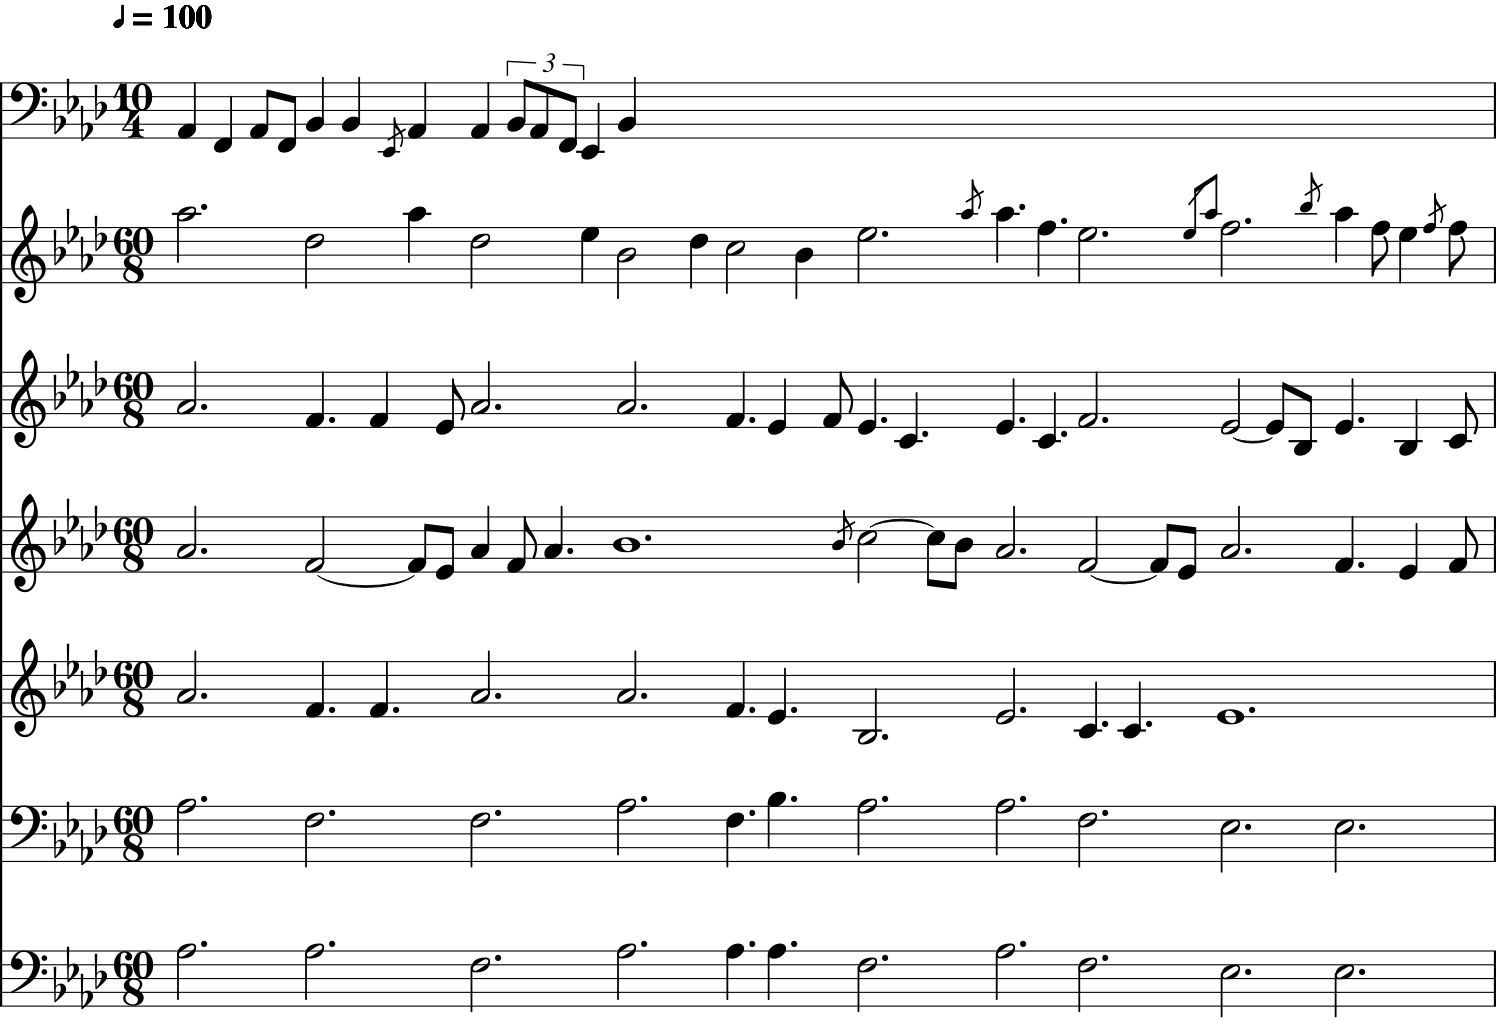

In [33]:
src, _, _ = val_dataset[0]

score = stream.Score()
for i in range(6):
  src_conv, out, (att_out,cat_out, _ ) = model.shifted_inference(src, i)
  if i == 0:
    score.insert(0, scr_decoder(src_conv))
  score.insert(0, decoder(out))
score.show()

In [34]:
score.write('musicxml', fp='orchestra_test.musicxml')

PosixPath('/home/teo/userdata/git_libraries/Yeominrak/orchestra_test.musicxml')

In [10]:
out

[[1, 68.0, 3.0, 3.0, 'weak', 0],
 [1, 65.0, 3.0, 6.0, 'weak', 0],
 [1, 65.0, 1.5, 7.5, 'weak', 0],
 [1, 68.0, 0.5, 8.0, 'none', 0],
 [1, 58.0, 1.0, 9.0, 'middle', 0],
 [1, 56.0, 0.0, 9.0, 'middle', 0],
 [1, 63.0, 3.0, 12.0, 'weak', 0],
 [1, 60.0, 1.5, 13.5, 'weak', 0],
 [1, 60.0, 0.5, 14.0, 'none', 0],
 [1, 58.0, 1.0, 15.0, 'strong', 0],
 [1, 63.0, 3.0, 18.0, 'weak', 0],
 [1, 61.0, 1.5, 19.5, 'weak', 0],
 [1, 65.0, 0.5, 20.0, 'none', 0],
 [1, 65.0, 1.0, 21.0, 'middle', 0],
 [1, 63.0, 3.0, 24.0, 'weak', 0],
 [1, 65.0, 3.0, 27.0, 'weak', 0],
 [1, 68.0, 1.5, 28.5, 'weak', 0],
 [1, 65.0, 0.5, 29.0, 'none', 0],
 [1, 63.0, 1.0, 0.0, 'strong', 1],
 [1, 65.0, 3.0, 3.0, 'weak', 1],
 [1, 68.0, 1.5, 4.5, 'weak', 1],
 [1, 65.0, 1.0, 5.5, 'none', 1],
 [1, 63.0, 0.5, 6.0, 'weak', 1],
 [1, 68.0, 0.0, 6.0, 'weak', 1],
 [1, 68.0, 3.0, 9.0, 'middle', 1],
 [1, 65.0, 3.0, 12.0, 'weak', 1],
 [1, 63.0, 1.5, 13.5, 'weak', 1],
 [1, 68.0, 0.0, 13.5, 'weak', 1],
 [1, 65.0, 0.75, 14.25, 'none', 1],
 [1, 63.0, 0.

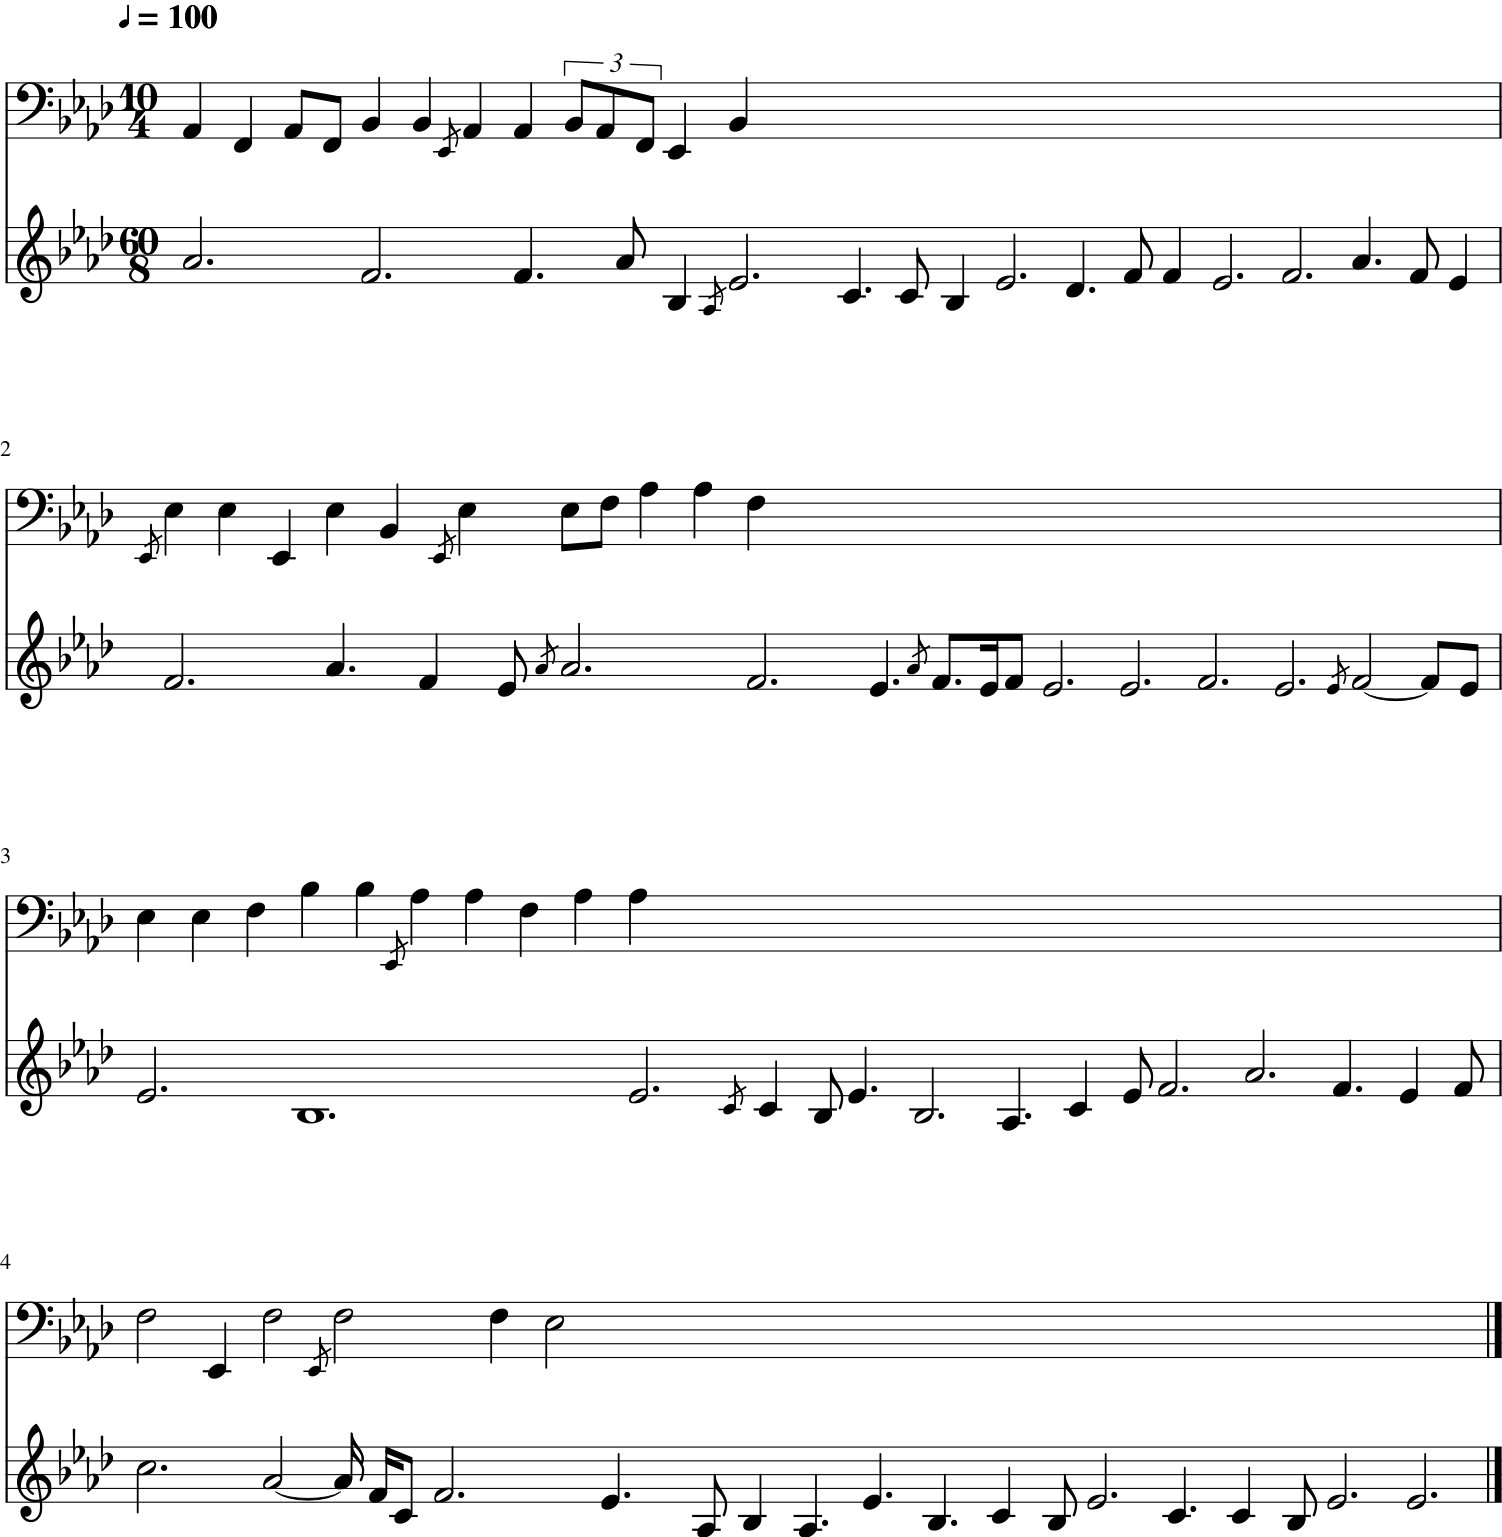

In [16]:

src_stream = scr_decoder(src)
gen = decoder(out)

score = stream.Score()
score.insert(0, src_stream)
score.insert(0, gen)
score.show()

In [2]:


def make_experiment_name_with_date(config):
  current_time_in_str = datetime.datetime.now().strftime("%m%d-%H%M")
  return f'{current_time_in_str}_{config.general.exp_name}_{config.dataset_class}_{config.model_class}'


config = OmegaConf.load('yamls/orchestration.yaml')
config.general.make_log = False
config = get_emb_total_size(config)
if 'duration' not in config.model.features:
  config.model.features.append('duration')
if 'sampling_rate' in config.data and 'samlping_rate' not in config.model:
  config.model.sampling_rate = config.data.sampling_rate

if config.general.make_log:
  wandb.init(
    project="yeominrak", 
    entity="dasaem", 
    name = make_experiment_name_with_date(config), 
    config = OmegaConf.to_container(config)
  )
  save_dir = Path(wandb.run.dir) / 'checkpoints'
else:
  save_dir = Path('wandb/debug/checkpoints')

# original_wd = Path(hydra.utils.get_original_cwd())
# if not save_dir.is_absolute():
#   save_dir = original_wd / save_dir

dataset_class = getattr(yeominrak_processing, config.dataset_class)
model_class = getattr(model_zoo, config.model_class)

train_dataset = dataset_class(is_valid= False, 
                              xml_path='yeominlak_omr5.musicxml',
                              use_pitch_modification = config.data.use_pitch_modification, 
                              pitch_modification_ratio=config.data.modification_ratio,
                              min_meas=config.data.min_meas, 
                              max_meas=config.data.max_meas,
                              feature_types=config.model.features,
                              sampling_rate=config.data.sampling_rate
                              )
val_dataset = dataset_class(is_valid= True,
                            # valid_measure_num = [i for i in range(93, 99)],
                            xml_path='yeominlak_omr5.musicxml', 
                            use_pitch_modification=False, 
                            slice_measure_num=config.data.max_meas,
                            min_meas=config.data.min_meas,
                            feature_types=config.model.features,
                              sampling_rate=config.data.sampling_rate)

train_loader = DataLoader(train_dataset, batch_size=config.train.batch_size , shuffle=True, collate_fn=pack_collate)
valid_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, collate_fn=pack_collate, drop_last=True)

device = 'cuda:1'

measure_match_exp = []
similarity_exp = []
beat_pitch_match_exp = []
total_iteration = 0




In [3]:

model = model_class(train_dataset.era_dataset.tokenizer, train_dataset.tokenizer, config.model).to(device)


model.is_condition_shifted = isinstance(train_dataset, yeominrak_processing.ShiftedAlignedScore)
optimizer = torch.optim.Adam(model.parameters(), lr=config.train.lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.99)
scheduler = None
save_dir.mkdir(parents=True, exist_ok=True)
loss_fn = nll_loss

if config.dataset_class == "SamplingScore":
  trainer_class = "RollTrainer"
else:
  trainer_class = "Trainer"

atrainer:Trainer = getattr(trainer, trainer_class)(model=model, optimizer=optimizer, 
                  loss_fn=loss_fn, train_loader=train_loader, 
                  valid_loader=valid_loader, device = device, save_log=config.general.make_log, 
                  save_dir=save_dir, 
                  scheduler=scheduler)
atrainer.iteration = total_iteration


In [42]:
isinstance(train_dataset, yeominrak_processing.ShiftedAlignedScore)

True

In [32]:
len(train_dataset.slice_info)

206

In [33]:
len(train_dataset.era_dataset.slice_info)

142

In [34]:
len(train_dataset.era_dataset.parts[-1])

160

In [35]:
len(train_dataset.parts[-1])

224

In [36]:
train_dataset.era_dataset.measure_features[-1][96]

[[7, 53.0, 2.0, 0.0, 'strong', 97],
 [7, 39.0, 1.0, 2.0, 'weak', 97],
 [7, 53.0, 2.0, 3.0, 'middle', 97],
 [7, 39.0, 0.0, 5.0, 'strong', 97],
 [7, 53.0, 2.0, 5.0, 'strong', 97],
 [7, 53.0, 1.0, 7.0, 'middle', 97],
 [7, 51.0, 2.0, 8.0, 'weak', 97]]

In [37]:
train_dataset.measure_features[-1][96]

[[5, 53.0, 6.0, 0.0, 'strong', 97],
 [5, 39.0, 3.0, 6.0, 'weak', 97],
 [5, 53.0, 6.0, 9.0, 'middle', 97],
 [5, 53.0, 6.0, 15.0, 'strong', 97],
 [5, 53.0, 3.0, 21.0, 'middle', 97],
 [5, 51.0, 6.0, 24.0, 'weak', 97]]

In [38]:
len(train_dataset)

141

In [39]:
for i in range(len(train_dataset)):
  train_dataset[i]

In [41]:
atrainer.train_by_num_epoch(50)


  0%|          | 0/50 [00:00<?, ?it/s]

[tensor([[[1.3901e-03, 1.5678e-03, 1.3724e-01,  ..., 1.3411e-02,
           1.3411e-02, 1.3411e-02],
          [5.3890e-01, 3.8723e-01, 7.9382e-01,  ..., 1.8008e-02,
           1.8008e-02, 1.8008e-02],
          [5.5816e-02, 5.5779e-02, 2.5319e-02,  ..., 1.7720e-02,
           1.7720e-02, 1.7720e-02],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],
 
         [[5.6468e-10, 9.3658e-14, 4.7085e-12,  ..., 1.2861e-02,
           1.2861e-02, 1.2861e-02],
          [5.5357e-05, 3.0733e-10, 1.3774e-08,  ..., 1.7937e-02,
           1.7937e-02, 1.7937e-02],
          [1.8705e-05, 9.4088e-11, 7.0930e-09,  ..., 1.7699e-02,
           1.7699e-02, 1.7699e-02],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.000

In [6]:
model.tokenizer.vocab['duration']

['pad',
 'start',
 'end',
 8.0,
 0.0,
 0.25,
 0.5,
 0.75,
 1.0,
 1.25,
 1.5,
 2.0,
 2.25,
 2.5,
 2.75,
 3.0,
 3.5,
 4.0,
 4.25,
 4.5,
 5.0,
 5.25,
 5.5,
 6.0,
 6.5,
 7.5,
 9.0,
 9.5,
 10.5,
 12.0,
 15.0]

In [4]:
3/4 in model.tokenizer.vocab['offset']

False

In [ ]:

atrainer.train_by_num_epoch(config.train.num_epoch)

atrainer.load_best_model()

atrainer.make_inference_result(write_png=True)
atrainer.make_sequential_inference_result(write_png=True)
# measure_match, similarity, beat_pitch_match = atrainer.make_inference_result(loader=test_loader)
# measure_match_exp.append(measure_match)
# similarity_exp.append(similarity)
# beat_pitch_match_exp.append(beat_pitch_match)
total_iteration = atrainer.iteration




In [29]:
from yeominrak_processing import AlignedScore, ShiftedAlignedScore
import torch
import random

class OrchestraScore(ShiftedAlignedScore):
  def __init__(self,xml_path='0_edited.musicxml', 
                valid_measure_num = [i for i in range(93, 104)],
                slice_measure_num = 2, 
                is_valid = False, 
                use_pitch_modification=False, 
                pitch_modification_ratio=0.3, 
                min_meas=3, 
                max_meas=6,
                feature_types=['index', 'pitch', 'duration', 'offset', 'dynamic', 'measure_idx'],
                sampling_rate=None) -> None:
    self.dynamic_template = {x/2: 'weak' for x in range(0, 90, 3)}
    self.dynamic_template[0.0] =  'strong'
    self.dynamic_template[15.0] =  'strong'
    self.dynamic_template[9.0] =  'middle'
    self.dynamic_template[21.0] =  'middle'
    super().__init__(xml_path, valid_measure_num, slice_measure_num, is_valid, use_pitch_modification, pitch_modification_ratio, min_meas, max_meas, feature_types, sampling_rate)
    self.era_dataset = ShiftedAlignedScore(xml_path='0_edited.musicxml')
    valid_list = list(range(len(self.parts)))
    self.result_pairs = [[7, b] for b in valid_list]
    self.result_pairs = [pair+[i]  for pair in self.result_pairs for i in self.slice_info]

  def get_feature(self, part_idx):
    part = self.parts[part_idx]
    measure_set = []
    for measure_idx, measure in enumerate(part.measures):
        each_measure = []
        for note in measure:
            each_measure.append(self._get_feature_by_note(note, part_idx))
        measure_set.append(each_measure) 
    return measure_set  
  
  def _get_feature_by_note(self, note, part_idx):
    features = [part_idx]
    # if 'pitch' in self.tokenizer.key_types:
    features.append(note.pitch)
    # if 'duration' in self.tokenizer.key_types:
    features.append(note.duration)
    if 'offset' in self.tokenizer.key_types:
        features.append(note.measure_offset)
    if 'dynamic' in self.tokenizer.key_types:
        features.append(self.dynamic_template.get(note.measure_offset, 'none'))
    if 'measure_idx' in self.tokenizer.key_types:
        features.append(note.measure_number)
    if 'measure_change' in self.tokenizer.key_types:
        changed = 1 if note.measure_offset == 0.0 else 0
        features.append(changed)
    return features

  def fix_part_by_rule(self):
    return
  
  def get_processed_feature(self, front_part_idx, back_part_idx, idx):
    source_start_token = [front_part_idx, 'start', 'start', 'start', 'start', 'start']
    source_end_token = [front_part_idx, 'end', 'end', 'end', 'end', 'end']
    target_start_token = [back_part_idx, 'start', 'start', 'start', 'start', 'start']
    target_end_token = [back_part_idx, 'end', 'end', 'end', 'end', 'end']
    if self.is_valid:
        measure_list = idx
    else:    
        measure_list = self.slice_info[idx]

    original_source_list = [item for idx in measure_list for item in self.era_dataset.measure_features[front_part_idx][idx]]
    original_target_list = [item for idx in measure_list for item in self.measure_features[back_part_idx][idx]]
    for i, idx in enumerate(measure_list):
        if len(self.era_dataset.measure_features[front_part_idx][idx]) == 0:
            return torch.LongTensor([[]]), torch.LongTensor([[]]), torch.LongTensor([[]])
        if len(self.measure_features[back_part_idx][idx]) == 0:
            return torch.LongTensor([[]]), torch.LongTensor([[]]), torch.LongTensor([[]])

    if 'measure_idx' in self.tokenizer.key_types:
      m_idx_pos = self.tokenizer.key2idx['measure_idx']
      source_first_measure_idx = original_source_list[0][m_idx_pos]
      target_first_measure_idx = original_target_list[0][m_idx_pos]

      original_source_list = [note[:m_idx_pos] + [note[m_idx_pos]-source_first_measure_idx] + note[m_idx_pos+1:] for note in original_source_list]
      original_target_list = [note[:m_idx_pos] + [note[m_idx_pos]-target_first_measure_idx] + note[m_idx_pos+1:] for note in original_target_list]

    
    source_list = [source_start_token] + original_source_list + [source_end_token]
    target_list = [target_start_token] + original_target_list
    if self.use_pitch_modification and not self.is_valid:
        target_list = self.modify_pitch(target_list)
    shifted_target_list = original_target_list + [target_end_token]
    # print(target_list, shifted_target_list)
    source = [self.era_dataset.tokenizer(note_feature) for note_feature in source_list]
    target = [self.tokenizer(note_feature) for note_feature in target_list]
    shifted_target = [self.tokenizer(note_feature) for note_feature in shifted_target_list]
    
    return torch.LongTensor(source), torch.LongTensor(target), torch.LongTensor(shifted_target)
    
  def __len__(self):
     return len(self.era_dataset)

  def __getitem__(self, idx):
    if self.is_valid:
      front_part_idx, back_part_idx, measure_idx = self.result_pairs[idx]
      src, tgt, shifted_tgt = self.get_processed_feature(front_part_idx, back_part_idx, measure_idx)
      
      return src, tgt, shifted_tgt
    
    sample_success = False
    while not sample_success:
      # front_part_idx = random.choice(range(len(self.parts)-1))
      front_part_idx = 7
      back_part_idx = random.randint(0, len(self.parts)-1)
      src, tgt, shifted_tgt = self.get_processed_feature(front_part_idx, back_part_idx, idx)          
      if len(src) > 2 and len(tgt) > 1:
        sample_success = True
    return src, tgt, shifted_tgt    

dataset = OrchestraScore(xml_path='yeominlak_omr.musicxml')

In [30]:
dataset[0]

(tensor([[ 7,  1,  1,  1,  1,  1],
         [ 7, 12,  8,  3,  3,  3],
         [ 7,  5,  4,  5,  5,  3],
         [ 7, 12, 11,  5,  5,  3],
         [ 7, 12,  8, 11,  4,  3],
         [ 7,  9,  6, 15,  5,  3],
         [ 7, 12,  6, 17,  5,  3],
         [ 7,  5,  4, 19,  3,  3],
         [ 7, 12,  8, 19,  3,  3],
         [ 7, 12,  8, 22,  5,  3],
         [ 7, 10,  8, 25,  4,  3],
         [ 7,  9,  8, 29,  5,  3],
         [ 7, 13,  8, 32,  5,  3],
         [ 7,  9,  6,  3,  3,  4],
         [ 7, 12,  6,  4,  5,  4],
         [ 7,  5,  4,  5,  5,  4],
         [ 7, 12,  8,  5,  5,  4],
         [ 7, 12,  8,  7,  5,  4],
         [ 7, 10,  6, 11,  4,  4],
         [ 7, 12,  6, 13,  5,  4],
         [ 7, 13,  6, 15,  5,  4],
         [ 7, 15,  6, 17,  5,  4],
         [ 7,  5,  4, 19,  3,  4],
         [ 7, 15,  8, 19,  3,  4],
         [ 7, 15,  8, 22,  5,  4],
         [ 7, 13,  8, 25,  4,  4],
         [ 7, 12,  8, 29,  5,  4],
         [ 7, 12,  8, 32,  5,  4],
         [ 7,  7,  4

In [3]:
org_score = ShiftedAlignedScore()

In [ ]:
org_score.measure_features[-1][10]

[[7, 51.0, 0.5, 0.0, 'strong', 11],
 [7, 48.0, 0.5, 0.5, 'weak', 11],
 [7, 53.0, 1.0, 1.0, 'weak', 11],
 [7, 39.0, 1.0, 2.0, 'weak', 11],
 [7, 53.0, 1.0, 3.0, 'middle', 11],
 [7, 56.0, 1.0, 4.0, 'weak', 11],
 [7, 39.0, 0.0, 5.0, 'strong', 11],
 [7, 53.0, 1.0, 5.0, 'strong', 11],
 [7, 58.0, 1.0, 6.0, 'weak', 11],
 [7, 56.0, 0.5, 7.0, 'middle', 11],
 [7, 53.0, 0.5, 7.5, 'weak', 11],
 [7, 51.0, 1.0, 8.0, 'weak', 11],
 [7, 51.0, 1.0, 9.0, 'weak', 11]]

In [20]:
dataset[2]

(tensor([[  1,   1,   1,   1,   1,   1],
         [  1,  17,   7,   3,   3,   3],
         [  1,  21,  14,   5,   6,   3],
         [  1,  15,  17,  14,   5,   3],
         [  1,  19,   9,  26,   5,   3],
         [  1,  17,   7,  29,   6,   3],
         [  1,  21,  11,  31,   5,   3],
         [  1,  26,  11,  37,   4,   3],
         [  1,  24,  11,  43,   5,   3],
         [  1,  19,   7,  49,   5,   3],
         [  1,  23,  14,  51,   6,   3],
         [  1,  33,  13,  59,   3,   3],
         [  1,  19,   8,  67,   6,   3],
         [  1,  17,  17,  70,   5,   3],
         [  1,  17,  26,  82,   4,   3],
         [  1,  17,  11, 111,   5,   3],
         [  1,  26,  17,   3,   3,   4],
         [  1,  24,  11,  14,   5,   4],
         [  1,  23,   9,  20,   5,   4],
         [  1,  27,   4,  24,   6,   4],
         [  1,  24,   7,  24,   6,   4],
         [  1,  26,  17,  26,   5,   4],
         [  1,  25,   7,  37,   4,   4],
         [  1,  28,   9,  39,   6,   4],
         [  1,  